In [27]:
import random
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras import preprocessing, models, layers, applications, optimizers, callbacks, backend

warnings.filterwarnings('ignore')

In [28]:
def is_on_kaggle():
    import os
    if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        print("Running on Kaggle")
        return True
    else:
        print("Running on Local env")
        return False

In [29]:
root = "/kaggle/input/vehical-4-class-1/dataset" if is_on_kaggle() else "dataset"

data_path = Path(root)
train_dir = data_path / "train"
val_dir = data_path / "validation"
test_dir = data_path / "test"

Running on Local env


<center><b><h1>GET DATAFRAME</h1></b></center>

In [30]:
def get_df(dirname: Path):
    data = []
    for label in [d for d in dirname.iterdir() if d.is_dir()]:
        for filename in [f for f in label.iterdir() if f.is_file()]:
            data.append({'label': label.name, 'filepath': filename})
    df = pd.DataFrame(data)
    return df


train_df = get_df(train_dir)
val_df = get_df(val_dir)
test_df = get_df(test_dir)

<center><b><h1>UTILS</h1></b></center>

In [31]:
class MetricsPlotter(callbacks.Callback):
    def __init__(self):
        self.epochs = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs.append(epoch)
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)

        self.plot_metrics()

    def plot_metrics(self):
        metrics = [m for m in self.history.keys() if not m.startswith('val_')]
        for metric in metrics:
            plt.figure()
            plt.plot(self.epochs, self.history[metric], label=metric)
            plt.plot(self.epochs, self.history['val_' + metric], label='val_' + metric)
            plt.xlabel('Epochs')
            plt.ylabel(metric)
            plt.legend()
            plt.title(f'{metric} over epochs')
            plt.savefig(f'{metric}_over_epochs.png')
            plt.close()


def f1_score(y_true, y_pred):
    y_pred = backend.round(y_pred)
    tp = backend.sum(backend.cast(y_true * y_pred, 'float'), axis=0)
    fp = backend.sum(backend.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = backend.sum(backend.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + backend.epsilon())
    r = tp / (tp + fn + backend.epsilon())

    f1 = 2 * p * r / (p + r + backend.epsilon())
    f1 = backend.mean(f1)
    return f1


def scheduler(epoch, lr):
    if epoch < warmup_epochs:
        return initial_learning_rate + (epoch / warmup_epochs) * initial_learning_rate
    else:
        return initial_learning_rate * np.exp(-0.1 * (epoch - warmup_epochs))
    

<center><b><h1>CONST</h1></b></center>

In [32]:
# DATA PREPARATION
CLASSES = len(train_df['label'].unique())
print(f"Number of classes: {CLASSES}")
HEIGHT, WIDTH = 224, 224
BATCH_SIZE = 256
print(f"Batch size: {BATCH_SIZE}")

# TRAIN
EPOCH = 150
print(f"Train in {EPOCH} Epochs")

print(f"\nUsing Warm up Strategy")
initial_learning_rate = 1e-4
OPTIM = optimizers.Adam(learning_rate=initial_learning_rate)
print(f"Using Optimizer Adam with initial leaning rate: {initial_learning_rate}")
LOSS = "categorical_crossentropy"
print(f"Loss : {LOSS}")
METRICS = [f1_score, "accuracy"]
print(f"\nUsing metric F1 & Accuracy")

# EARLY STOPPING
PATIENCE = 15
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

print(f"\nUsing ealy stopping with patience: {PATIENCE}\nmonitor: {early_stopping.monitor}")
# AUTO CHECKPOINT
checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# TRACKING METRICS
metrics_plotter = MetricsPlotter()

# LR SCHEDULER
print("\nWarm up Info")
warmup_epochs = int(EPOCH / 100 * 15)
decay_after_warmup = (EPOCH - warmup_epochs)
lr_scheduler = callbacks.LearningRateScheduler(scheduler)
print(f"Warm up phase: {warmup_epochs} Epochs")
print(f"decay phase: {decay_after_warmup} Epochs")

# SET UP CALLBACKS
CALLBACKS = [early_stopping, checkpoint, metrics_plotter, lr_scheduler]

Number of classes: 4
Batch size: 256
Train in 150 Epochs

Using Warm up Strategy
Using Optimizer Adam with initial leaning rate: 0.0001
Loss : categorical_crossentropy

Using metric F1 & Accuracy

Using ealy stopping with patience: 15
monitor: val_loss

Warm up Info
Warm up phase: 22 Epochs
decay phase: 128 Epochs


<center><b><h1>VISUALIZE</h1></b></center>

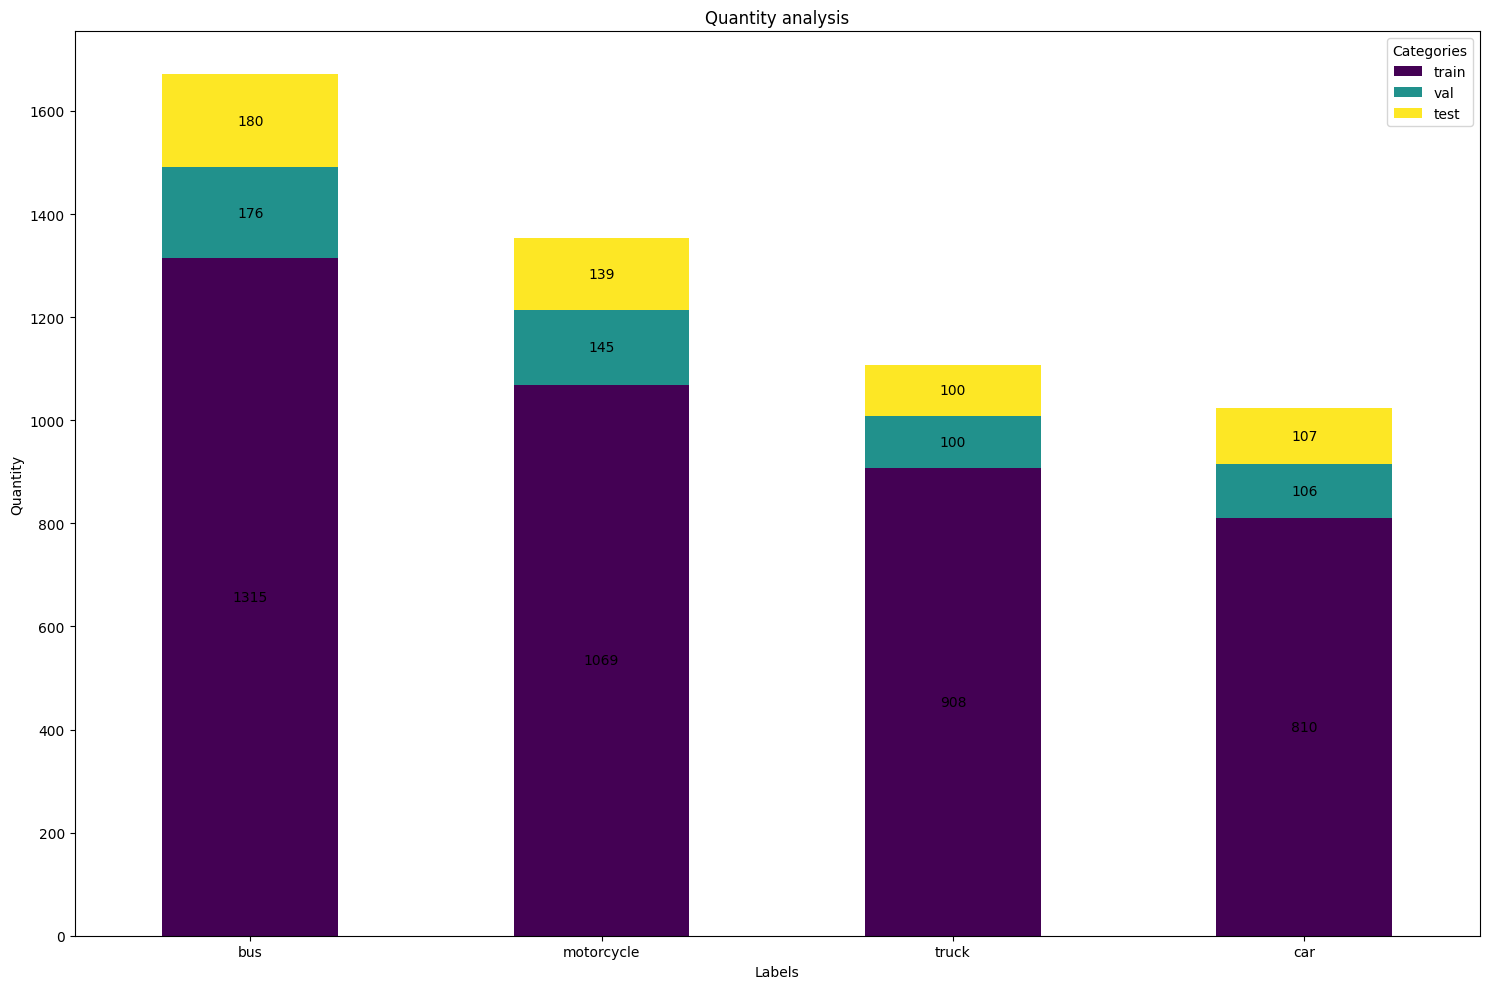

In [33]:
train_counts = train_df['label'].value_counts().rename('train')
val_counts = val_df['label'].value_counts().rename('val')
test_counts = test_df['label'].value_counts().rename('test')

counts_df = pd.concat([train_counts, val_counts, test_counts], axis=1).fillna(0)

ax = counts_df.plot(kind='bar', stacked=True, figsize=(15, 10), colormap='viridis')
plt.title('Quantity analysis')
plt.xlabel('Labels')
plt.ylabel('Quantity')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Categories')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.annotate(f'{int(height)}', (x + width / 2, y + height / 2), ha='center', va='center')

plt.tight_layout()
plt.show()

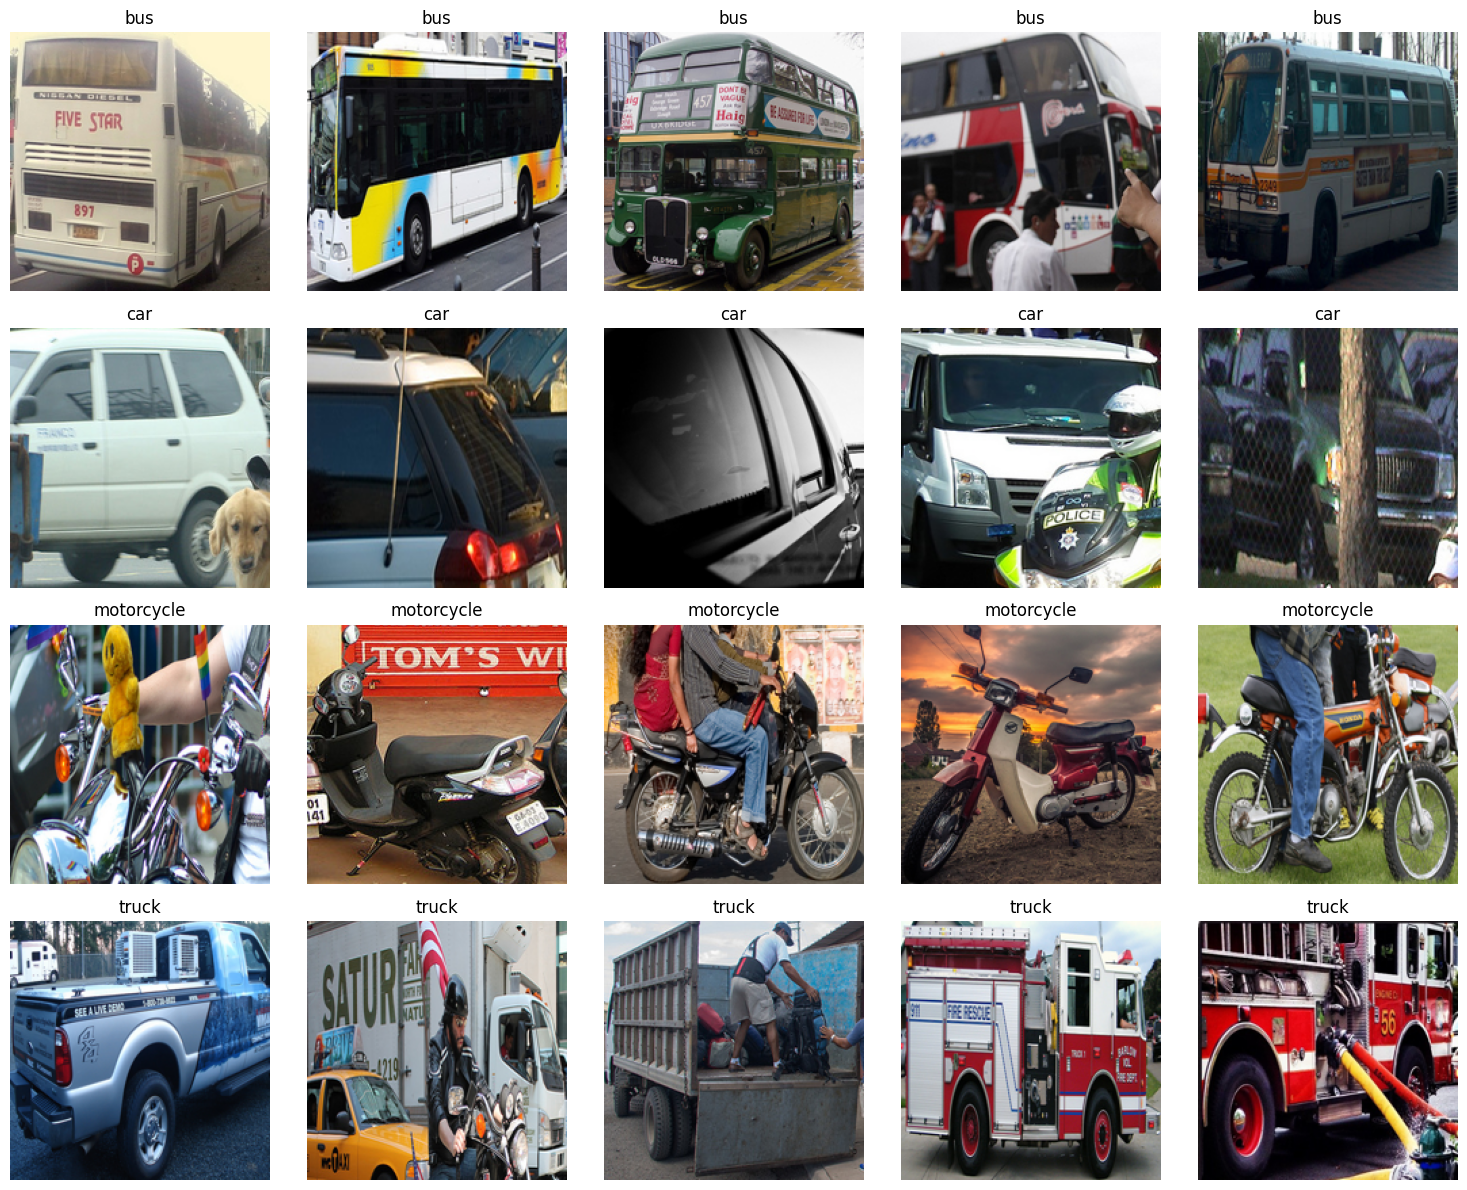

In [34]:
def show_random_images(df, n=5):
    labels = df['label'].unique()
    fig, axes = plt.subplots(len(labels), n, figsize=(n * 3, len(labels) * 3))

    if len(labels) == 1:
        axes = [axes]

    for i, label in enumerate(labels):
        files = df[df['label'] == label]['filepath'].tolist()
        sample_files = random.sample(files, min(n, len(files)))

        for j, file in enumerate(sample_files):
            ax = axes[i, j] if len(labels) > 1 else axes[j]
            img = Image.open(file)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(label)

        # Fill in any remaining subplots with empty images
        for j in range(len(sample_files), n):
            ax = axes[i, j] if len(labels) > 1 else axes[j]
            ax.axis('off')

    plt.tight_layout()
    plt.show()


show_random_images(train_df, n=5)

<center><b><h1>DATA LOADER</h1></b></center>

In [35]:
train_data_gen = preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_data_gen = preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
test_data_gen = preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_data_gen.flow_from_directory(
    directory=train_dir.absolute(),
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_data_gen.flow_from_directory(
    directory=val_dir.absolute(),
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_data_gen.flow_from_directory(
    directory=test_dir.absolute(),
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 4100 images belonging to 4 classes.
Found 527 images belonging to 4 classes.
Found 526 images belonging to 4 classes.


<center><b><h1>MODEL</h1></b></center>

In [36]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(CLASSES, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 27,308,868 (104.18 MB)

 Trainable params: 12,594,180 (48.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(
    optimizer=OPTIM,
    loss=LOSS,
    metrics=METRICS
)

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCH,
    callbacks=CALLBACKS
)

Epoch 1/150
